In [12]:
import numpy as np
import torch
import scipy
from PIL import Image
from sklearn.feature_extraction.image import extract_patches_2d, reconstruct_from_patches_2d
import cv2
import time
import matplotlib.pyplot as plt
from utils import extract_blocks, compute_metrics, normalize_image

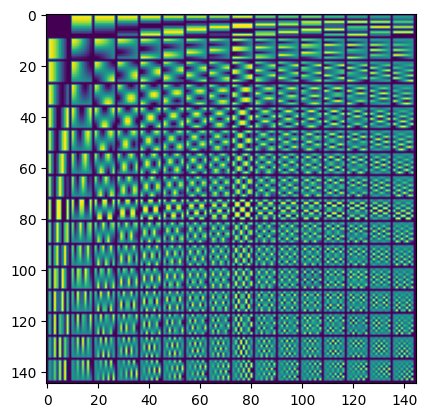

In [2]:
class DCTDictionary:
    """
    The Dictionary class is more or less a wrapper around the numpy array class. It holds a numpy ndarray in
    the attribute `matrix` and adds some useful functions for it. The dictionary elements can be accessed
    either by D.matrix[i,j] or directly through D[i,j].

    """

    def __init__(self, n, K):
        
        D = self.dictionary_from_transform(self.dctii, n, K, inverse=False)
        self.matrix = np.array(D)
        self.shape = self.matrix.shape


    def to_img(self):
        """
        Transforms the dictionary columns into patches and orders them for plotting purposes.

        Returns:
            Reordered dictionary matrix
        """
        # dictionary dimensions
        D = self.matrix
        n, K = D.shape
        M = self.matrix
        # stretch atoms
        for k in range(K):
            M[:, k] = M[:, k] - (M[:, k].min())
            if M[:, k].max():
                M[:, k] = M[:, k] / D[:, k].max()

        # patch size
        n_r = int(np.sqrt(n))

        # patches per row / column
        K_r = int(np.sqrt(K))

        # we need n_r*K_r+K_r+1 pixels in each direction
        dim = n_r * K_r + K_r + 1
        V = np.ones((dim, dim)) * np.min(D)

        # compute the patches
        patches = [np.reshape(D[:, i], (n_r, n_r)) for i in range(K)]

        # place patches
        for i in range(K_r):
            for j in range(K_r):
                V[j * n_r + 1 + j:(j + 1) * n_r + 1 + j, i * n_r + 1 + i:(i + 1) * n_r + 1 + i] = patches[
                    i * K_r + j]
        return V

    def dctii(self, v, normalized=True, sampling_factor=None):
        """
        Computes the inverse discrete cosine transform of type II,
        cf. https://en.wikipedia.org/wiki/Discrete_cosine_transform#DCT-II

        Args:
            v: Input vector to transform
            normalized: Normalizes the output to make output orthogonal
            sampling_factor: Can be used to "oversample" the input to create overcomplete dictionaries

        Returns:
            Discrete cosine transformed vector
        """
        n = v.shape[0]
        K = sampling_factor if sampling_factor else n
        y = np.array([sum(np.multiply(v, np.cos((0.5 + np.arange(n)) * k * np.pi / K))) for k in range(K)])
        if normalized:
            y[0] = 1 / np.sqrt(2) * y[0]
            y = np.sqrt(2 / n) * y
        return y


    def dictionary_from_transform(self, transform, n, K, normalized=True, inverse=True):
        """
        Builds a Dictionary matrix from a given transform

        Args:
            transform: A valid transform (e.g. Haar, DCT-II)
            n: number of rows transform dictionary
            K: number of columns transform dictionary
            normalized: If True, the columns will be l2-normalized
            inverse: Uses the inverse transform (as usually needed in applications)

        Returns:
            Dictionary build from the Kronecker-Delta of the transform applied to the identity.
        """
        H = np.zeros((K, n))
        for i in range(n):
            v = np.zeros(n)
            v[i] = 1.0
            H[:, i] = transform(v, sampling_factor=K)
        if inverse:
            H = H.T
        return np.kron(H.T, H.T)
    

# create dictionary
dct_dictionary = DCTDictionary(8, 16)
# plot dictionary
plt.imshow(dct_dictionary.to_img())
plt.show()

In [3]:
# use the DCT transform to learn an overcomplete D dictionary
# use OMP to select only some elements from the overcomplete dictionary
# reconstruct the image 
# Step 1: Learn an Overcomplete D Dictionary using DCT
im = Image.open("Figures/noisy_image0_noise_lvl25.jpg")
# im = im.resize((512, 512))
im_gray = np.array(im.convert('L'))

def dct2(a):
    return scipy.fftpack.dct(scipy.fftpack.dct( a, axis=0, norm='ortho' ), axis=1, norm='ortho' )

def idct2(a):
    return scipy.fftpack.idct( scipy.fftpack.idct( a, axis=0 , norm='ortho'), axis=1 , norm='ortho')

def learn_overcomplete_dictionary(image, block_size=(8, 8), num_atoms=128):
    # Extract blocks from image
    blocks = extract_blocks(image, block_size)
    
    # Initialize D_overcomplete matrix
    D_overcomplete = np.zeros((block_size[0] * block_size[1], num_atoms))
    
    # Iterate over blocks to fill D_overcomplete with DCT atoms
    for i in range(num_atoms):
        # Choose a random block index
        random_index = np.random.randint(len(blocks))
        block = blocks[random_index]
        # Compute DCT of the block
        dct_block = dct2(block.reshape(block_size))
        
        # Reshape and store the DCT coefficients as a column in D_overcomplete
        D_overcomplete[:, i] = dct_block.flatten()
    
    return D_overcomplete


D_overcomplete = learn_overcomplete_dictionary(im_gray,  block_size=(8, 8), num_atoms=128)
print(D_overcomplete.shape)

(64, 128)


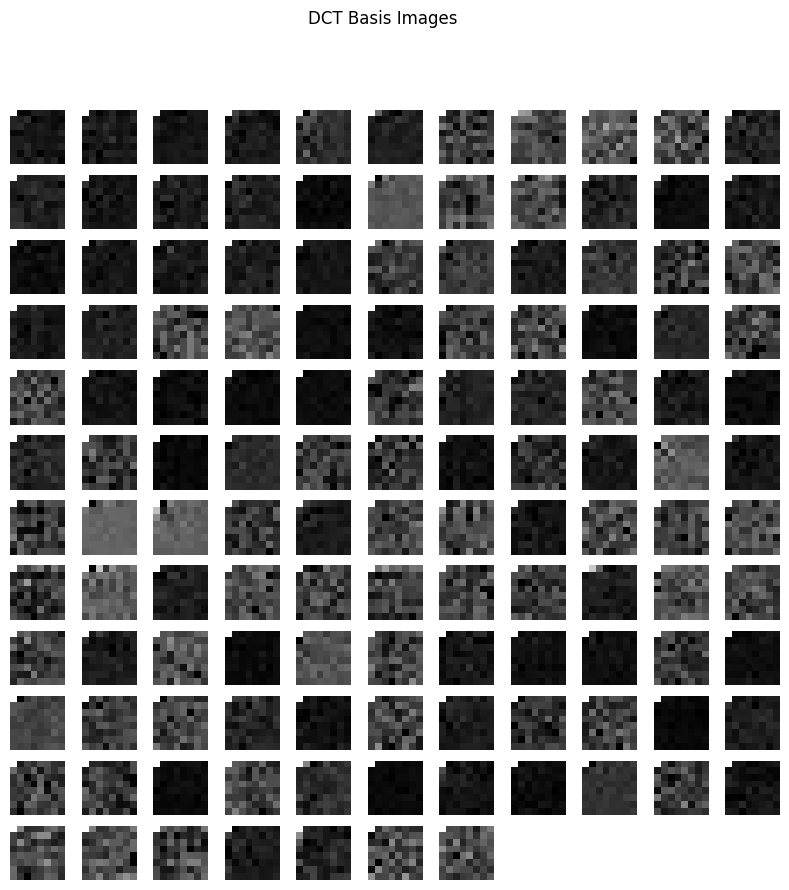

In [4]:
def plot_dct_basis(D_overcomplete, block_size=(8, 8)):
    num_atoms = D_overcomplete.shape[1]
    num_rows, num_cols = block_size
    
    # Determine the number of rows and columns in the plot grid
    grid_rows = int(np.ceil(np.sqrt(num_atoms)))
    grid_cols = int(np.ceil(num_atoms / grid_rows))
    
    # Create a figure and axis objects
    fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(10, 10))
    
    # Iterate over the columns of D_overcomplete and plot each basis image
    for i in range(num_atoms):
        basis_image = D_overcomplete[:, i].reshape(block_size)
        
        # Determine the subplot index
        row_index = i // grid_cols
        col_index = i % grid_cols
        
        # Plot the basis image
        axes[row_index, col_index].imshow(basis_image, cmap='gray')
        axes[row_index, col_index].axis('off')
    
    # Remove empty subplot placeholders
    for i in range(num_atoms, grid_rows * grid_cols):
        row_index = i // grid_cols
        col_index = i % grid_cols
        fig.delaxes(axes[row_index, col_index])
    
    plt.suptitle('DCT Basis Images')
    plt.show()

# Assuming D_overcomplete is already computed
# Plot the DCT basis images
plot_dct_basis(D_overcomplete,  block_size=(8, 8))


## Apply OMP on the DCT matrix

In [5]:
# Extract all reference patches from the left half of the image
print("Extracting reference patches...")
t0 = time.time()
patch_size = (8, 8)
data = extract_patches_2d(im_gray, patch_size)
data = data.astype(np.float64)
data = data.reshape(data.shape[0], -1)
data -= np.mean(data, axis=0)
data /= np.std(data, axis=0)
print(f"{data.shape[0]} patches extracted in %.2fs." % (time.time() - t0))

Extracting reference patches...
148836 patches extracted in 0.09s.


In [6]:
D_overcomplete.shape

(64, 128)

In [7]:
from sklearn.linear_model import OrthogonalMatchingPursuit as OMP
sparsity_level = 8
denoised_patches = []
for i, reference_patch in enumerate(data):
    if i % 1000 == 0:
        print(f"Processing reference patch {i + 1}/{len(data)}...")
    
    # Apply the OMP algorithm to obtain the sparse representation
   
    omp = OMP(n_nonzero_coefs=sparsity_level)
    # print(f"{D_overcomplete.shape=}; {reference_patch.shape=}")
    omp.fit(D_overcomplete, reference_patch)
    gamma = omp.coef_

    # Reconstruct the denoised patch using the sparse representation and the overcomplete dictionary
    denoised_patch = D_overcomplete @ gamma.flatten()
    
    # Add the intercept (mean) to the denoised patch
    denoised_patch += np.mean(reference_patch)
    
    # Append the denoised patch to the list of denoised patches
    denoised_patches.append(denoised_patch.reshape(patch_size))


Processing reference patch 1/148836...
Processing reference patch 1001/148836...
Processing reference patch 2001/148836...
Processing reference patch 3001/148836...
Processing reference patch 4001/148836...
Processing reference patch 5001/148836...
Processing reference patch 6001/148836...
Processing reference patch 7001/148836...
Processing reference patch 8001/148836...
Processing reference patch 9001/148836...
Processing reference patch 10001/148836...
Processing reference patch 11001/148836...
Processing reference patch 12001/148836...
Processing reference patch 13001/148836...
Processing reference patch 14001/148836...
Processing reference patch 15001/148836...
Processing reference patch 16001/148836...
Processing reference patch 17001/148836...
Processing reference patch 18001/148836...
Processing reference patch 19001/148836...
Processing reference patch 20001/148836...
Processing reference patch 21001/148836...
Processing reference patch 22001/148836...
Processing reference pat

In [8]:
denoised_patches = np.array(denoised_patches)

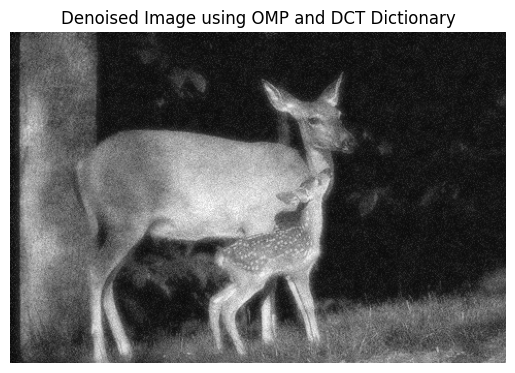

In [9]:
# Assemble the denoised patches into the final denoised image
data = extract_patches_2d(im_gray, patch_size=(8,8))
denoised_image = reconstruct_from_patches_2d(denoised_patches, im_gray.shape)

# Display the denoised image
plt.imshow(denoised_image, cmap='gray')
plt.title('Denoised Image using OMP and DCT Dictionary')
plt.axis('off')
plt.show()



In [13]:
im_gray = normalize_image(im_gray)
denoised_image = normalize_image(denoised_image)

rmse, psnr = compute_metrics(im_gray, denoised_image)

print(f"RMSE: {rmse:.4f}")
print(f"PSNR: {psnr:.4f}")

RMSE: 20.0041
PSNR: 22.1084


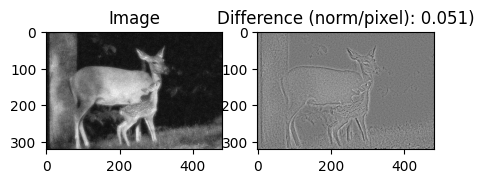

In [15]:
from utils import show_with_diff

show_with_diff(denoised_image, im_gray, title='')